# Netflix-IMDb Machine Learning Final Project
## Alyx Cleveland and Tony Barrows

Let's first download and gather our data for review.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures

random_state = 42

This is a very large data set, so let's dispense with it as quickly as we can. We need to download the *names* data set in order to get the primary key, merge on the *ratings* data set, and finally merge that again with the *netflix* data set.

In [2]:
def load_data_live():
    ''' Load Netflix data set from disk. Load IMDb data sets from IMDb website. Merge on title, write merged
    version to disk.'''
    nflix = pd.read_csv("../data/netflix_titles.csv")
    imdb_names = pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", compression='gzip', delimiter = "\t",
                            low_memory = False)
    imdb_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", compression = 'gzip', delimiter = "\t",
                              low_memory = False)

    # just need the unique id 'tconst'
    imdb_names = imdb_names[['tconst', 'originalTitle']]
    imdb = imdb_ratings.merge(imdb_names, how = 'left', on = 'tconst')

    nflix = nflix.merge(imdb, how = 'left', left_on = 'title', right_on = 'originalTitle')
    nflix.to_csv("../data/nflix_merged.csv")
    
    return nflix

# only pull from by API if not on disk
try:
    nflix = pd.read_csv("../data/nflix_merged.csv")
except:
    nflix = load_data_live()

In [3]:
nflix

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,tconst,averageRating,numVotes,originalTitle
0,0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,tt2096351,7.8,2053.0,3%
1,1,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,tt4922804,7.4,21771.0,3%
2,2,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,tt5979312,6.0,567.0,7:19
3,3,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",tt2100376,4.6,849.0,23:59
4,4,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",tt0191312,6.0,73.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22408,22408,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,tt3776484,6.1,389.0,Zubaan
22409,22409,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,tt7368392,7.3,10.0,Zubaan
22410,22410,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast...",NaN,NaN,NaN,NaN
22411,22411,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...,tt7239256,6.9,1864.0,Zumbo's Just Desserts


In [4]:
nflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22413 entries, 0 to 22412
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     22413 non-null  int64  
 1   show_id        22413 non-null  object 
 2   type           22413 non-null  object 
 3   title          22413 non-null  object 
 4   director       15336 non-null  object 
 5   cast           20796 non-null  object 
 6   country        21150 non-null  object 
 7   date_added     22356 non-null  object 
 8   release_year   22413 non-null  int64  
 9   rating         22406 non-null  object 
 10  duration       22413 non-null  object 
 11  listed_in      22413 non-null  object 
 12  description    22413 non-null  object 
 13  tconst         20304 non-null  object 
 14  averageRating  20304 non-null  float64
 15  numVotes       20304 non-null  float64
 16  originalTitle  20304 non-null  object 
dtypes: float64(2), int64(2), object(13)
memory usage: 

_______

TODO:
* Weight ratings by number of votes (or use as separate targets: i.e., num votes is measure of popularity)
    - Might be a relationship between number of votes and ratings

* Make a binned version of IMDb ratings for classification methods
* Text pre-processing
* Feature selection
    - e.g., Ridge Regression or LASSO selection
* Algorithm definition
    - Write algorithms in pseducode (in LaTeX) -- likely forest methods
    - MSE or RMSE to describe bias-variance tradeoff 
    - Plot these.

*******

### Descriptives

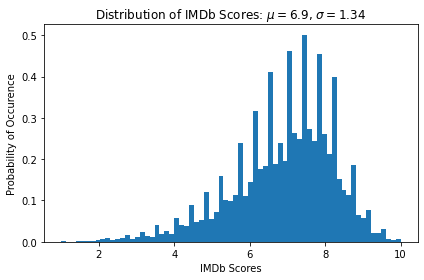

In [5]:
avg = np.mean(nflix['averageRating'])
sd = np.std(nflix['averageRating'])
title = 'Distribution of IMDb Scores: $\mu=$' + str(round(avg, 2)) + ', $\sigma=$' + str(round(sd, 2))

plt.hist(nflix['averageRating'], density = True, bins = 'auto')
plt.xlabel('IMDb Scores')
plt.ylabel('Probability of Occurence')
plt.title(title)

plt.tight_layout()
# plt.savefig('../out/imdb_histogram.png', dpi=600)
plt.show()

********

## Reshaping/Preprocessing

We want to change the structure of the data to substantially reduce the complexity of the input features. Let's first separate things into structures that make sense. This is mainly a text processing problem.

Split 'title' and 'description' by every space:

In [6]:
# make a copy
nflix_sub = nflix.copy()
nflix_sub['title'] = nflix_sub['title'].str.split(' ')
nflix_sub['title']

0                                                    [3%]
1                                                    [3%]
2                                                  [7:19]
3                                                 [23:59]
4                                                     [9]
                               ...                       
22408                                            [Zubaan]
22409                                            [Zubaan]
22410                              [Zulu, Man, in, Japan]
22411                           [Zumbo's, Just, Desserts]
22412    [ZZ, TOP:, THAT, LITTLE, OL', BAND, FROM, TEXAS]
Name: title, Length: 22413, dtype: object

We also want to remove unnecessary conjoining (i.e. 'stop') words and punctuation from the description in order to reduce its size and maximize its feature importance:

In [7]:
stop = text.ENGLISH_STOP_WORDS

# coerce to lowercase to match stop words
nflix_sub['description'] = nflix_sub['description'].str.lower()
nflix_sub['description'] = nflix_sub['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
nflix_sub['description'] = nflix_sub['description'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
nflix_sub['description']

0        future elite inhabit island paradise far crowd...
1        future elite inhabit island paradise far crowd...
2        devastating earthquake hits mexico trapped sur...
3        army recruit fellow soldiers forced confront t...
4        postapocalyptic robots hide fear dangerous mac...
                               ...                        
22408    scrappy poor boy worms way dysfunctional facin...
22409    scrappy poor boy worms way dysfunctional facin...
22410    south african rapper nasty c hits stage street...
22411    dessert wizard adriano zumbo looks tense compe...
22412    documentary delves mystique trio explores enig...
Name: description, Length: 22413, dtype: object

In [8]:
nflix_sub['description'] = nflix_sub['description'].str.split(' ')
nflix_sub['description']

0        [future, elite, inhabit, island, paradise, far...
1        [future, elite, inhabit, island, paradise, far...
2        [devastating, earthquake, hits, mexico, trappe...
3        [army, recruit, fellow, soldiers, forced, conf...
4        [postapocalyptic, robots, hide, fear, dangerou...
                               ...                        
22408    [scrappy, poor, boy, worms, way, dysfunctional...
22409    [scrappy, poor, boy, worms, way, dysfunctional...
22410    [south, african, rapper, nasty, c, hits, stage...
22411    [dessert, wizard, adriano, zumbo, looks, tense...
22412    [documentary, delves, mystique, trio, explores...
Name: description, Length: 22413, dtype: object

Split cast on commas:

In [9]:
nflix_sub['cast'] = nflix_sub['cast'].str.split(',')
nflix_sub['cast']

0        [João Miguel,  Bianca Comparato,  Michel Gomes...
1        [João Miguel,  Bianca Comparato,  Michel Gomes...
2        [Demián Bichir,  Héctor Bonilla,  Oscar Serran...
3        [Tedd Chan,  Stella Chung,  Henley Hii,  Lawre...
4        [Elijah Wood,  John C. Reilly,  Jennifer Conne...
                               ...                        
22408    [Vicky Kaushal,  Sarah-Jane Dias,  Raaghav Cha...
22409    [Vicky Kaushal,  Sarah-Jane Dias,  Raaghav Cha...
22410                                            [Nasty C]
22411                        [Adriano Zumbo,  Rachel Khoo]
22412                                                  NaN
Name: cast, Length: 22413, dtype: object

Now, entries which were large text strings are now represented as lists of much smaller strings.

In [10]:
nflix_sub = nflix_sub[['title', 'director', 'cast', 'country', 'date_added', 'rating',
           'release_year', 'duration', 'description','averageRating', 'numVotes']]
nflix_sub.to_csv('../data/nflix_sub.csv')

### Frequency of unique terms

In [11]:
def count_unique(col):
    col = col.dropna()
    return len(set(itertools.chain.from_iterable(col)))

list_features = ['title', 'cast', 'description']

for f in list_features:
    print(f, ": ", str(count_unique(nflix_sub[f])))

title :  9384
cast :  35372
description :  15420


In [12]:
# above method doesn't work on single entries
single_features = ['director', 'duration', 'country', 'rating']

for f in single_features:
    print(f, ":", len(set(nflix_sub[f].dropna())))

director : 4049
duration : 216
country : 681
rating : 14


*******

## Feature Engineering and Algorithms

Update: taking a different approach to feature extraction.

### Detect missingness

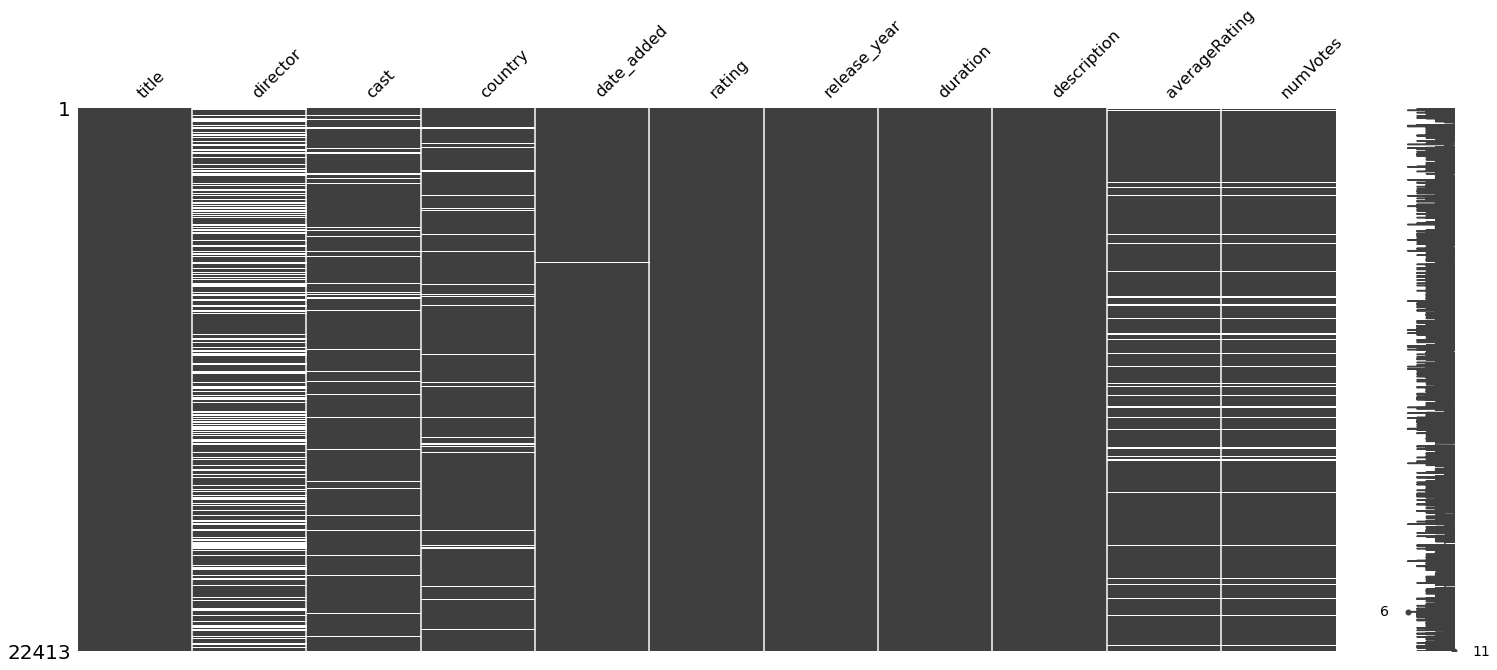

In [13]:
# create susbset of useful columns
nflix_sub = nflix[['title', 'director', 'cast', 'country', 'date_added', 'rating',
           'release_year', 'duration', 'description','averageRating', 'numVotes']]

# drop entries without response variable
nflix = nflix[nflix['averageRating'].isna() == False]

# nifty little missing data visualizer: https://github.com/ResidentMario/missingno.git
msno.matrix(nflix_sub)
# plt.savefig('../out/merged_missing.png', dpi=300, bbox_inches='tight')
plt.show()

The amount of missingness in the `director` column might make it a poor candidate to use in prediction.

### Encoding Data

In [14]:
df = nflix_sub
df = df.drop(['director'], axis=1)
df = df.dropna()


# df_sub = df.sample(frac=0.1, random_state=random_state)


y = df['averageRating']
X = df.drop(columns=['averageRating'])



In [15]:
# split into train and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

# vectorize training and testing features (separately)

def vectorize_data(X_train, X_test):
    '''Takes corpus of feature words and returns sparse tf-idf-vectorized matrix.
    Handles test and training data with different methods.'''
    
    vectorizer = text.TfidfVectorizer(analyzer='word', stop_words='english', lowercase=True,
                                     max_features = 1000, use_idf=False, dtype=np.float64, ngram_range = (2,2))
    
    train_out = pd.DataFrame(vectorizer.fit_transform(X_train).todense())
    test_out = pd.DataFrame(vectorizer.transform(X_test).todense())
    
    return train_out, test_out

# desc_tr, desc_ts = vectorize_data(X_train['description'], X_test['description'])
cast_tr, cast_ts = vectorize_data(X_train['cast'], X_test['cast'])
# title_tr, title_ts = vectorize_data(X_train['title'], X_test['title'])

cast_tr.shape

(14447, 1000)

## Plot Descriptives

In [16]:
df['date_added'] = pd.to_datetime(df['date_added'])
df['release_year'] = pd.to_numeric(df['release_year'])

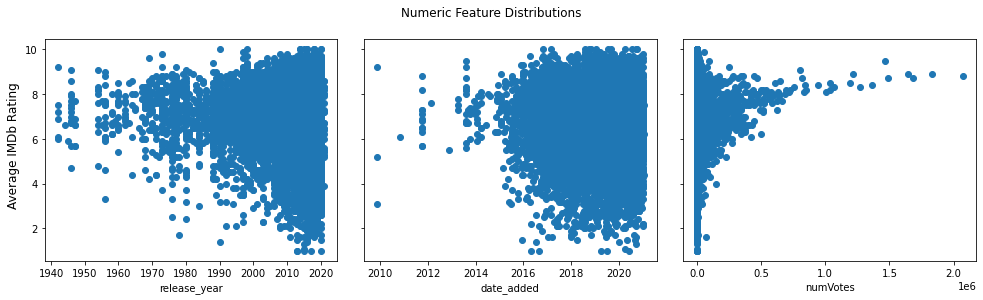

In [23]:
num_plts = ['release_year', 'date_added', 'numVotes']

nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows, ncols, sharey=True, figsize=(14,4))
fig.suptitle('Numeric Feature Distributions')
fig.supylabel('Average IMDb Rating')
fig.tight_layout()
for i in range(len(num_plts)):
    axs[i].scatter(df[num_plts[i]], df['averageRating'])
    axs[i].set_xlabel(num_plts[i])
    
